In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [78]:
#!pip install scikit-uplift

In [79]:
#!pip install catboost 
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

# !pip install causalml   -- не работает

### 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [80]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


### 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [81]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [82]:
 df['treatment'].value_counts(normalize=True)

1    0.667094
0    0.332906
Name: treatment, dtype: float64

### 3. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [83]:
# добавим dummy variables
df = pd.get_dummies(df)
df.head(3)

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1


### Вопрос - Создав dummy variables мне ну нужно создавать параметр estimator_fit_params={'cat_features': cat_features}

### 4. сделать разбиение набора данных не тренировочную и тестовую выборки

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], 1), df['target'], random_state=0)

### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

### одна модель с признаком коммуникации (S learner)

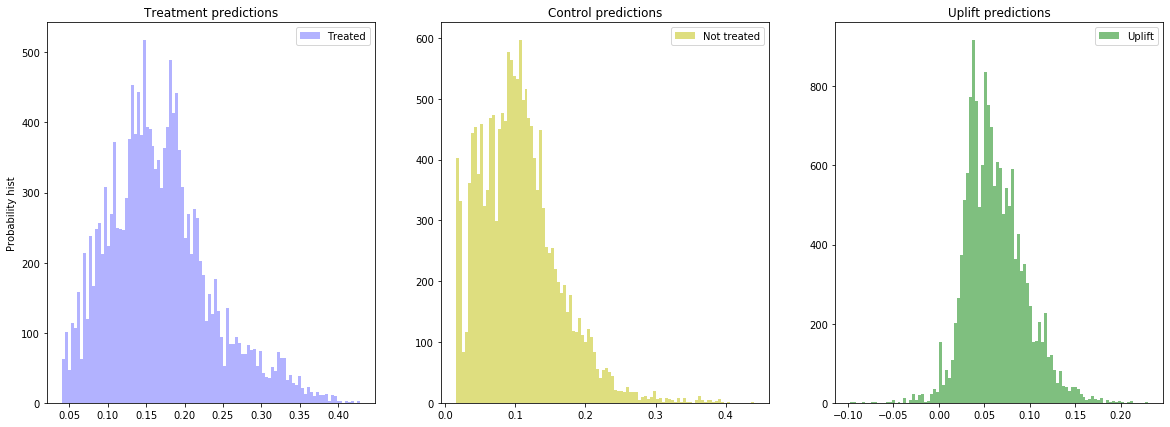

In [85]:
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

treat_train = X_train.treatment
treat_test = X_test.treatment

# делаю без Cat Features так как я уже создал Dummy Variables

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [86]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi.head()

,feature_name,feature_score
0,is_referral,18.155308
1,treatment,17.942577
2,used_bogo,12.768646
3,recency,12.061491
4,history,11.675302


### модель с трансформацией таргета (Class Transformation)

In [87]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

### две независимые модели (Two Models)

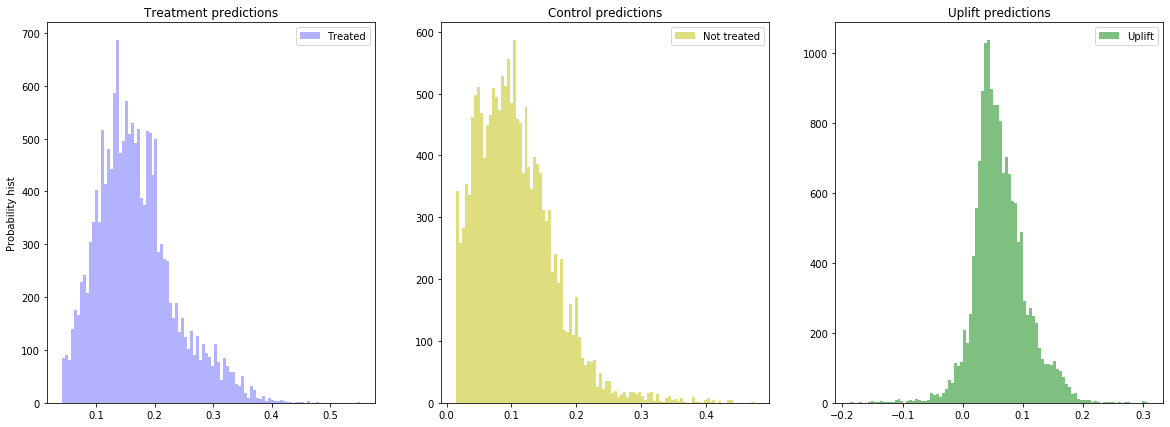

In [92]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)


models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

### 6. вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [93]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.237697,0.188810
0,SoloModel,0.067078,0.074294
2,TwoModels,0.049152,0.067131
3,TwoModels,0.049152,0.067131


### 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [90]:
X_train_tree = X_train
features = [col for col in X_train_tree]

In [91]:

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=6, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml'

Пока не решил проблему с установкой causaulml